
## All necessary imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import networkx as nx
from torch.utils.data.dataset import Dataset
from collections import defaultdict
from graph_rnn_tools import TorchShowers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential
from torch.distributions import Bernoulli
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import PackedSequence
import pyro
import pyro.distributions as dist
from itertools import product
import pickle
from collections import deque
from random import shuffle
from graph_rnn import GraphRNN
from graph_rnn_tools import decode_adj, preprocess_shower_for_graphrnn
from features_nn import FeaturesGCN
from tqdm import tqdm
from collections import namedtuple
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_sequence, pad_packed_sequence
import torch_geometric.transforms as T
import torch_cluster
import torch_geometric
shower_adj = namedtuple('shower_adj', field_names=['x', 'adj', 'ele_p'])
SCALE_SPATIAL = 1e5

matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
sns.set(font_scale=1)
sns.set_style("whitegrid")
sns.set_context("talk")


def collate_fn(x):
    return x

In [2]:
!nvidia-smi

Mon Nov 25 21:38:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.37                 Driver Version: 396.37                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00006506:00:00.0 Off |                    0 |
| N/A   55C    P0    75W / 149W |   2995MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00007FCE:00:00.0 Off |                    0 |
| N/A   69C    P0    65W / 149W |   2475MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
max_prev_node = 8
embedding_size = 196
edge_rnn_embedding_size = 16
device = torch.device('cuda:1')


model = GraphRNN(input_size=max_prev_node, 
                 embedding_size=embedding_size, # embedding_size of linear layer
                 output_size=edge_rnn_embedding_size, 
                 has_output=True, 
                 hidden_size=embedding_size, 
                 num_layers=4, 
                 has_input=False).to(device)

edge_nn = GraphRNN(input_size=1, 
                   embedding_size=edge_rnn_embedding_size,
                   hidden_size=edge_rnn_embedding_size, 
                   num_layers=4, 
                   has_input=True, 
                   has_output=True, 
                   output_size=1).to(device)

features_nn = FeaturesGCN(dim_in=embedding_size + 3,
                          embedding_size=4,
                          num_layers_gcn=3,
                          num_layers_dense=0,
                          mixture_size=12,
                          dim_out=5).to(device=device)

In [4]:
experiment = '93f330f375b5442ab4d4fc5cef1d9d15'
prefix = '.'

model.load_state_dict(torch.load('{}/graph_nn_{}.pcl'.format(prefix, experiment)))
model.eval()

edge_nn.load_state_dict(torch.load('{}/edge_nn_{}.pcl'.format(prefix, experiment)))
edge_nn.eval()

features_nn.load_state_dict(torch.load('{}/features_nn_{}.pcl'.format(prefix, experiment)))
features_nn.eval()

FeaturesGCN(
  (wconv_in): EdgeConv(nn=Sequential(
    (0): Linear(in_features=398, out_features=4, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Tanh()
  ))
  (layers_gcn): ModuleList(
    (0): EdgeConv(nn=Sequential(
      (0): Linear(in_features=8, out_features=4, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): Tanh()
    ))
    (1): EdgeConv(nn=Sequential(
      (0): Linear(in_features=8, out_features=4, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): Tanh()
    ))
    (2): EdgeConv(nn=Sequential(
      (0): Linear(in_features=8, out_features=4, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): Tanh()
    ))
  )
  (layers_dense): ModuleList()
  (out): GaussianMixtureNetwork(
    (logsoftmax): LogSoftmax()
    (softmax): Softmax(dim=1)
    (nn): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (alphas): Linear(in_fe

In [5]:
def loss_edges_over_predictions(edge_index, predictions):
    node_from = torch.index_select(predictions, dim=0, index=edge_index[0])
    node_to = torch.index_select(predictions, dim=0, index=edge_index[1])
    smoothness = torch.mean(opera_distance_metric(node_from, node_to))
    loss_mse = torch.nn.MSELoss()
    IP_left = loss_mse(node_from[:, -2:] * node_from[:, 2:3], node_to[:, :2])
    IP_right = loss_mse(node_to[:, -2:] * node_to[:, 2:3], node_from[:, :2])
    # TODO: special loss!
    return smoothness, IP_left, IP_right

def get_graph(adj):
    '''
    get a graph from zero-padded adj
    :param adj:
    :return:
    '''
    # remove all zeros rows and columns
    adj = adj[~np.all(adj == 0, axis=1)]
    adj = adj[:, ~np.all(adj == 0, axis=0)]
    adj = np.asmatrix(adj)
    G = nx.from_numpy_matrix(adj)
    return G

def generate_graph(model, edge_nn, features_nn, max_prev_node, test_batch_energies, device):
    test_batch_size = test_batch_energies.shape[0]
    
    # hidden_state = [num_layers, batch_size, hidden_size]
    model.eval()
    edge_nn.eval()
    features_nn.eval()

    # generate graphs
    max_num_node = 100
    
    # предсказания нейронки сэмплированные с помощью бернулли
    # y_pred = [batch_size, seq_length, max_nodes]
    y_pred_long = torch.ones(test_batch_size, 
                             max_num_node, 
                             max_prev_node).to(device) # discrete prediction
    
    # x_step = [batch_size, 1, max_nodes]
    # x_step = [batch_size, seq_length, max_nodes]
    # seq_length == 1
    model.hidden = model.init_hidden(test_batch_energies, test_batch_size)
    x_step = torch.ones(test_batch_size, 1, max_prev_node).to(device)
    embs = []
    for i in tqdm(range(max_num_node)):
        # output_raw_emb, output_raw, output_len
        # h = [test_batch, seq_length, output_size] # seq_length = 1
        emb, h, _ = model(x_step)
        embs.append(emb)
        # hidden_state = [num_layers, batch_size, hidden_size]
        hidden_null = torch.zeros(edge_nn.num_layers - 1, h.size(0), h.size(2)).to(device)
        edge_nn.hidden = torch.cat((h.permute(1, 0, 2), hidden_null), dim=0)  # num_layers, batch_size, hidden_size
        # sampling x_step from output h
        x_step = torch.zeros(test_batch_size, 1, max_prev_node).to(device)
        output_x_step = torch.ones(test_batch_size, 1, 1).to(device)
        for j in range(max_prev_node):
            # edge_emb = [batch_size, seq_length, hidden_size]
            # output_y_pred_step = [batch_size, seq_length, 1]
            edge_emb, output_y_pred_step, _ = edge_nn(output_x_step)
            if j < i + 1:
                output_x_step = Bernoulli(probs=torch.sigmoid(output_y_pred_step)).sample()
                x_step[:, :, j:j+1] = output_x_step
        print(x_step.sum(dim=2).view(-1))
        y_pred_long[:, i:i + 1, :] = x_step
    # TODO: need?
    emb, h, _ = model(x_step)
    embs.append(emb)
    
    embs = torch.cat(embs, dim=1)
    
    y_pred_long_data = y_pred_long.data.long()
    
    # save graphs as pickle
    # edges_emb = torch.cat(edges_emb, dim=1).view(test_batch_size, max_num_node, -1)
    # edges_emb = torch.cat([torch.ones(test_batch_size, 1, edges_emb.shape[2]).to(device), edges_emb], dim=1)
    
    showers = []
    
    for i in tqdm(range(test_batch_size)):
        plt.figure(figsize=(12, 8))
        plt.imshow(y_pred_long_data[i].detach().cpu().numpy().T)
        plt.show()
        adj_pred = decode_adj(y_pred_long_data[i].detach().cpu().numpy()[0:])
        emb = embs[i]
        # G_pred = get_graph(adj_pred) # get a graph from zero-padded adj
        G_pred = nx.from_numpy_matrix(adj_pred) # get a graph from zero-padded adj
        G_pred = max(nx.connected_component_subgraphs(G_pred), key=len)
        nodes = list(G_pred.nodes())
        G_pred = nx.bfs_tree(G_pred, nodes[0])
        adj_pred = nx.adjacency_matrix(G_pred).toarray()
        nodes = list(G_pred.nodes())
        emb = emb[nodes]
        G_pred = nx.DiGraph(adj_pred)
        
        # TODO: clean from nodes with 0 degree
        # for nodes with 
        node_in_degree = list(G_pred.in_degree())
        node_in_degree = sorted(node_in_degree, key=lambda x: x[0])
        node_in_degree = torch.tensor([nid[1] for nid in node_in_degree], dtype=torch.float32).to(device).view(-1, 1)

        node_out_degree = list(G_pred.out_degree())
        node_out_degree = sorted(node_out_degree, key=lambda x: x[0])
        node_out_degree = torch.tensor([nod[1] for nod in node_out_degree], dtype=torch.float32).to(device).view(-1, 1)
        
        node_order = torch.tensor(list(G_pred.nodes())).float().to(device).view(-1, 1) / 100.
        print(len(G_pred))
        if len(G_pred) <= 2: # TODO: is it correct?
            print('fuu')
            continue
            
        # pos = nx.layout.kamada_kawai_layout(G_pred)
        # nx.draw_networkx(G_pred, pos)
        # plt.show()
        
        edges = list(nx.bfs_edges(G_pred, 0))
        
        adj_out = torch.LongTensor(np.array(edges).T).to(device)
        
        shower_t = torch_geometric.data.Data(x=torch.cat([emb, node_in_degree, node_out_degree, node_order], dim=1), 
                                             edge_index=adj_out).to(device)
        
        # GCN to recover shower features
        x = features_nn.generate(shower_t)
        
        # return x # print(x)
        # x = features_nn.get_distr(shower_t); return x
        predictions = torch.zeros(len(shower_t.x), 5).to(device)
        for i, (j, k) in enumerate(shower_t.edge_index.t()):
            predictions[k] = predictions[j] + x[i]

        shower_t = torch_geometric.data.Data(x=predictions, 
                                             edge_index=shower_t.edge_index).to(device)
        showers.append(shower_t)

    return showers

In [6]:
SCALE_SPATIAL=1e4
DISTANCE = 1293. / SCALE_SPATIAL
EPS = 1e-5


def opera_distance_metric(basetrack_left, basetrack_right):
    # x, y, z, tx, ty
    # 0, 1, 2, 3, 4
    mask_swap = (basetrack_right[:, 2] < basetrack_left[:, 2])
    basetrack_right[mask_swap], basetrack_left[mask_swap] = basetrack_left[mask_swap], basetrack_right[mask_swap]
    dz = basetrack_right[:, 2] - basetrack_left[:, 2]

    dx = basetrack_left[:, 0] - (basetrack_right[:, 0] - basetrack_right[:, 3] * dz)
    dy = basetrack_left[:, 1] - (basetrack_right[:, 1] - basetrack_right[:, 4] * dz)

    dtx = basetrack_left[:, 3] - basetrack_right[:, 3]
    dty = basetrack_left[:, 4] - basetrack_right[:, 4]

    # dz = DISTANCE
    a = (dtx).pow(2) + (dty).pow(2)
    b = 2 * (dtx * dx + dty * dy)
    c = dx.pow(2) + dy.pow(2)

    mask = (a == torch.tensor(0., dtype=torch.float32).to(basetrack_left.device))
    result = torch.zeros_like(a)
    result[mask] = (torch.abs(torch.sqrt(c)) * dz / DISTANCE)[mask]

    a = a[~mask]
    b = b[~mask]
    c = c[~mask]
    discriminant = (b ** 2. - 4. * a * c)
    log_denominator = 2. * torch.sqrt(a) * torch.sqrt(torch.abs((a * dz + b) * dz + c)) + 2 * a * dz + b + EPS
    log_numerator = 2. * torch.sqrt(a) * torch.sqrt(c) + b + EPS
    first_part = ((2. * a * dz + b) * torch.sqrt(torch.abs(dz * (a * dz + b) + c)) - b * torch.sqrt(c)) / (4. * a)
    result[~mask] = torch.abs((discriminant * torch.log(torch.abs(log_numerator / log_denominator)) / (
                8. * torch.sqrt(a * a * a)) + first_part)) / DISTANCE

    return result


def loss_edges(edge_index, predictions):
    node_from = torch.index_select(predictions, dim=0, index=edge_index[0])
    node_to = torch.index_select(predictions, dim=0, index=edge_index[1])
    smoothness = torch.mean(opera_distance_metric(node_from, node_to))
    loss_mse = torch.nn.MSELoss()
    IP_left = loss_mse(node_from[:, 0:2] * node_from[:, 3:], node_to[:, :2])
    IP_right = loss_mse(node_to[:, 0:2] * node_to[:, 3:], node_from[:, :2])
    # TODO: special loss!
    return smoothness, IP_left, IP_right

In [7]:
def get_graph(adj):
    '''
    get a graph from zero-padded adj
    :param adj:
    :return:
    '''
    # remove all zeros rows and columns
    adj = adj[~np.all(adj == 0, axis=1)]
    adj = adj[:, ~np.all(adj == 0, axis=0)]
    adj = np.asmatrix(adj)
    G = nx.from_numpy_matrix(adj)
    return G

def generate_graph(model, edge_nn, features_nn, max_prev_node, test_batch_energies, device):
    test_batch_size = test_batch_energies.shape[0]
    
    # hidden_state = [num_layers, batch_size, hidden_size]
    model.train()
    edge_nn.train()
    features_nn.train()

    # generate graphs
    max_num_node = 250
    
    with torch.no_grad():

        # предсказания нейронки сэмплированные с помощью бернулли
        # y_pred = [batch_size, seq_length, max_nodes]
        y_pred_long = torch.ones(test_batch_size, 
                                 max_num_node, 
                                 max_prev_node).to(device) # discrete prediction

        # x_step = [batch_size, 1, max_nodes]
        # x_step = [batch_size, seq_length, max_nodes]
        # seq_length == 1
        model.hidden = model.init_hidden(test_batch_energies, test_batch_size)
        x_step = torch.ones(test_batch_size, 1, max_prev_node).to(device)
        embs = []
        for i in tqdm(range(max_num_node)):
            # output_raw_emb, output_raw, output_len
            # h = [test_batch, seq_length, output_size] # seq_length = 1
            emb, h, _ = model(x_step)
            embs.append(emb)
            # hidden_state = [num_layers, batch_size, hidden_size]
            hidden_null = torch.zeros(edge_nn.num_layers - 1, h.size(0), h.size(2)).to(device)
            edge_nn.hidden = torch.cat((h.permute(1, 0, 2), hidden_null), dim=0)  # num_layers, batch_size, hidden_size
            # sampling x_step from output h
            x_step = torch.zeros(test_batch_size, 1, max_prev_node).to(device)
            output_x_step = torch.ones(test_batch_size, 1, 1).to(device)
            for j in range(max_prev_node):
                # edge_emb = [batch_size, seq_length, hidden_size]
                # output_y_pred_step = [batch_size, seq_length, 1]
                edge_emb, output_y_pred_step, _ = edge_nn(output_x_step)
                if j < i + 1:
                    output_x_step = Bernoulli(probs=torch.sigmoid(output_y_pred_step)).sample()
                    x_step[:, :, j:j+1] = output_x_step
            y_pred_long[:, i:i + 1, :] = x_step
        # TODO: need?
        emb, h, _ = model(x_step)
        embs.append(emb)

        embs = torch.cat(embs, dim=1)

        y_pred_long_data = y_pred_long.data.long()

        # save graphs as pickle
        # edges_emb = torch.cat(edges_emb, dim=1).view(test_batch_size, max_num_node, -1)
        # edges_emb = torch.cat([torch.ones(test_batch_size, 1, edges_emb.shape[2]).to(device), edges_emb], dim=1)

        showers = []
        energies = []
        print(test_batch_size, test_batch_energies.shape)
        for i in tqdm(range(test_batch_size)):
            q = i
            # plt.figure(figsize=(12, 8))
            # plt.imshow(y_pred_long_data[i].detach().cpu().numpy().T)
            # plt.show()
            adj_pred = decode_adj(y_pred_long_data[i].detach().cpu().numpy()[0:])
            emb = embs[i]
            # G_pred = get_graph(adj_pred) # get a graph from zero-padded adj
            G_pred = nx.from_numpy_matrix(adj_pred) # get a graph from zero-padded adj
            G_pred = max(nx.connected_component_subgraphs(G_pred), key=len)
            nodes = list(G_pred.nodes())
            G_pred = nx.bfs_tree(G_pred, nodes[0])
            adj_pred = nx.adjacency_matrix(G_pred).toarray()
            nodes = list(G_pred.nodes())
            emb = emb[nodes]
            G_pred = nx.DiGraph(adj_pred)

            # TODO: clean from nodes with 0 degree
            # for nodes with 
            node_in_degree = list(G_pred.in_degree())
            node_in_degree = sorted(node_in_degree, key=lambda x: x[0])
            node_in_degree = torch.tensor([nid[1] for nid in node_in_degree], dtype=torch.float32).to(device).view(-1, 1)

            node_out_degree = list(G_pred.out_degree())
            node_out_degree = sorted(node_out_degree, key=lambda x: x[0])
            node_out_degree = torch.tensor([nod[1] for nod in node_out_degree], dtype=torch.float32).to(device).view(-1, 1)

            node_order = torch.tensor(list(G_pred.nodes())).float().to(device).view(-1, 1) / 100.

            if len(G_pred) <= 2: # TODO: is it correct?
                print('fuu')
                continue

            # pos = nx.layout.kamada_kawai_layout(G_pred)
            # nx.draw_networkx(G_pred, pos)
            # plt.show()

            edges = list(nx.bfs_edges(G_pred, 0))

            adj_out = torch.LongTensor(np.array(edges).T).to(device)


            shower_t = torch_geometric.data.Data(x=torch.cat([emb, node_in_degree, node_out_degree, node_order], dim=1), 
                                                 edge_index=adj_out).to(device)

            # GCN to recover shower features
            x = features_nn.generate(shower_t)
            # return x # print(x)
            # x = features_nn.get_distr(shower_t); return x
            predictions = torch.zeros(len(shower_t.x), 5).to(device)
            for i, (j, k) in enumerate(shower_t.edge_index.t()):
                predictions[k] = predictions[j] + x[i]

            showers.append(predictions.cpu().detach().numpy())
            energies.append(test_batch_energies[q][0].item())
    return showers, energies

In [8]:
E = torch.tensor(np.random.uniform(low=1, high=5, size=(10000, 1))).float().to(device)

In [9]:
g, energies = generate_graph(model=model, 
                   edge_nn=edge_nn,
                   features_nn=features_nn,
                   max_prev_node=max_prev_node, 
                   test_batch_energies=E,
                   # torch.tensor(np.random.uniform(0., 0., 20), dtype=torch.float32).to(device).view(-1, 1), 
                   device=device)

  0%|          | 2/10000 [00:00<10:41, 15.60it/s]

10000 torch.Size([10000, 1])


100%|██████████| 10000/10000 [04:23<00:00, 39.17it/s]


In [10]:
dZ = 205. # 0.0205 cm emulsion
DISTANCE = 1293.

def plot_npframe(data, azim=-84, elev=10, q=2):
    """
    Function for plotting shower
    """
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    import matplotlib.pyplot as plt
    x0, y0, z0, sx, sy = data.T

    x1 = x0 + dZ * sx
    y1 = y0 + dZ * sy
    z1 = z0 + dZ
    
    start_points = np.array([z0, y0, x0]).T.reshape(-1, 3)
    end_points = np.array([z1, y1, x1]).T.reshape(-1, 3)

    C = plt.cm.Greys(1.)
    lc = Line3DCollection(list(zip(start_points, end_points)), colors=C, alpha=0.9, lw=3)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    ax.add_collection3d(lc)
    
    ax.set_xlabel("z")
    ax.set_ylabel("y")
    ax.set_zlabel("x")
    ax.set_xlim(np.percentile(z0, q=q), np.percentile(z1, q=100 - q))
    ax.set_ylim(np.percentile(y0, q=q), np.percentile(y1, q=100 - q))
    ax.set_zlim(np.percentile(x0, q=q), np.percentile(x1, q=100 - q))
    
    plt.tight_layout()
    plt.show()

In [11]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
sns.set_context("talk")
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

In [12]:
lengths = []
x = []
y = []
z = []
tx = []
ty = []
mean_x = []
med_x = []
mean_y = []
med_y = []
mean_z = []
med_z = []
mean_tx = []
med_tx = []
mean_ty = []
med_ty = []
SCALE = 1e4
for j in g:
    X = j * np.array([SCALE, SCALE, SCALE, 1, 1])
    # plot_npframe(X)
    lengths.append(len(X))
    x.append(X[:, 0])
    y.append(X[:, 1])
    z.append(X[:, 2])
    tx.append(X[:, 3])
    ty.append(X[:, 4])
    mean_x.append(np.mean(X[:, 0]))
    med_x.append(np.median(X[:, 0]))
    mean_y.append(np.mean(X[:, 1]))
    med_y.append(np.median(X[:, 1]))
    mean_z.append(np.mean(X[:, 2]))
    med_z.append(np.median(X[:, 2]))
    mean_tx.append(np.mean(X[:, 3]))
    med_tx.append(np.median(X[:, 3]))
    mean_ty.append(np.mean(X[:, 4]))
    med_ty.append(np.median(X[:, 4]))
    
x = np.concatenate(x)
y = np.concatenate(y)
z = np.concatenate(z)
tx = np.concatenate(tx)
ty = np.concatenate(ty)

mean_x = np.array(mean_x)
med_x = np.array(med_x)
mean_y = np.array(mean_y)
med_y = np.array(med_y)
mean_z = np.array(mean_z)
med_z = np.array(med_z)
mean_tx = np.array(mean_tx)
med_tx = np.array(med_tx)
mean_ty = np.array(mean_ty)
med_ty = np.array(med_ty)

lengths = np.array(lengths)
energies = np.array(energies)

In [13]:
datafile = "./data/showers_all_energies_1_5.pkl"
showers = pickle.load(open(datafile, "rb"))

In [14]:
lengths_real = []
x_real = []
y_real = []
z_real = []
tx_real = []
ty_real = []
mean_x_real = []
med_x_real = []
mean_y_real = []
med_y_real = []
mean_z_real = []
med_z_real = []
mean_tx_real = []
med_tx_real = []
mean_ty_real = []
med_ty_real = []
energies_real = []
SCALE = 1e4
for j in showers:
    X = j.x[["SX", "SY", "SZ", "TX", "TY"]].values
    energies_real.append(j.ele_p)
    # plot_npframe(X)
    lengths_real.append(len(X))
    x_real.append(X[:, 0])
    y_real.append(X[:, 1])
    z_real.append(X[:, 2])
    tx_real.append(X[:, 3])
    ty_real.append(X[:, 4])
    mean_x_real.append(np.mean(X[:, 0]))
    med_x_real.append(np.median(X[:, 0]))
    mean_y_real.append(np.mean(X[:, 1]))
    med_y_real.append(np.median(X[:, 1]))
    mean_z_real.append(np.mean(X[:, 2]))
    med_z_real.append(np.median(X[:, 2]))
    mean_tx_real.append(np.mean(X[:, 3]))
    med_tx_real.append(np.median(X[:, 3]))
    mean_ty_real.append(np.mean(X[:, 4]))
    med_ty_real.append(np.median(X[:, 4]))
    
x_real = np.concatenate(x_real)
y_real = np.concatenate(y_real)
z_real = np.concatenate(z_real)
tx_real = np.concatenate(tx_real)
ty_real = np.concatenate(ty_real)

mean_x_real = np.array(mean_x_real)
med_x_real = np.array(med_x_real)
mean_y_real = np.array(mean_y_real)
med_y_real = np.array(med_y_real)
mean_z_real = np.array(mean_z_real)
med_z_real = np.array(med_z_real)
mean_tx_real = np.array(mean_tx_real)
med_tx_real = np.array(med_tx_real)
mean_ty_real = np.array(mean_ty_real)
med_ty_real = np.array(med_ty_real)

lengths_real = np.array(lengths_real)
energies_real = np.array(energies_real)

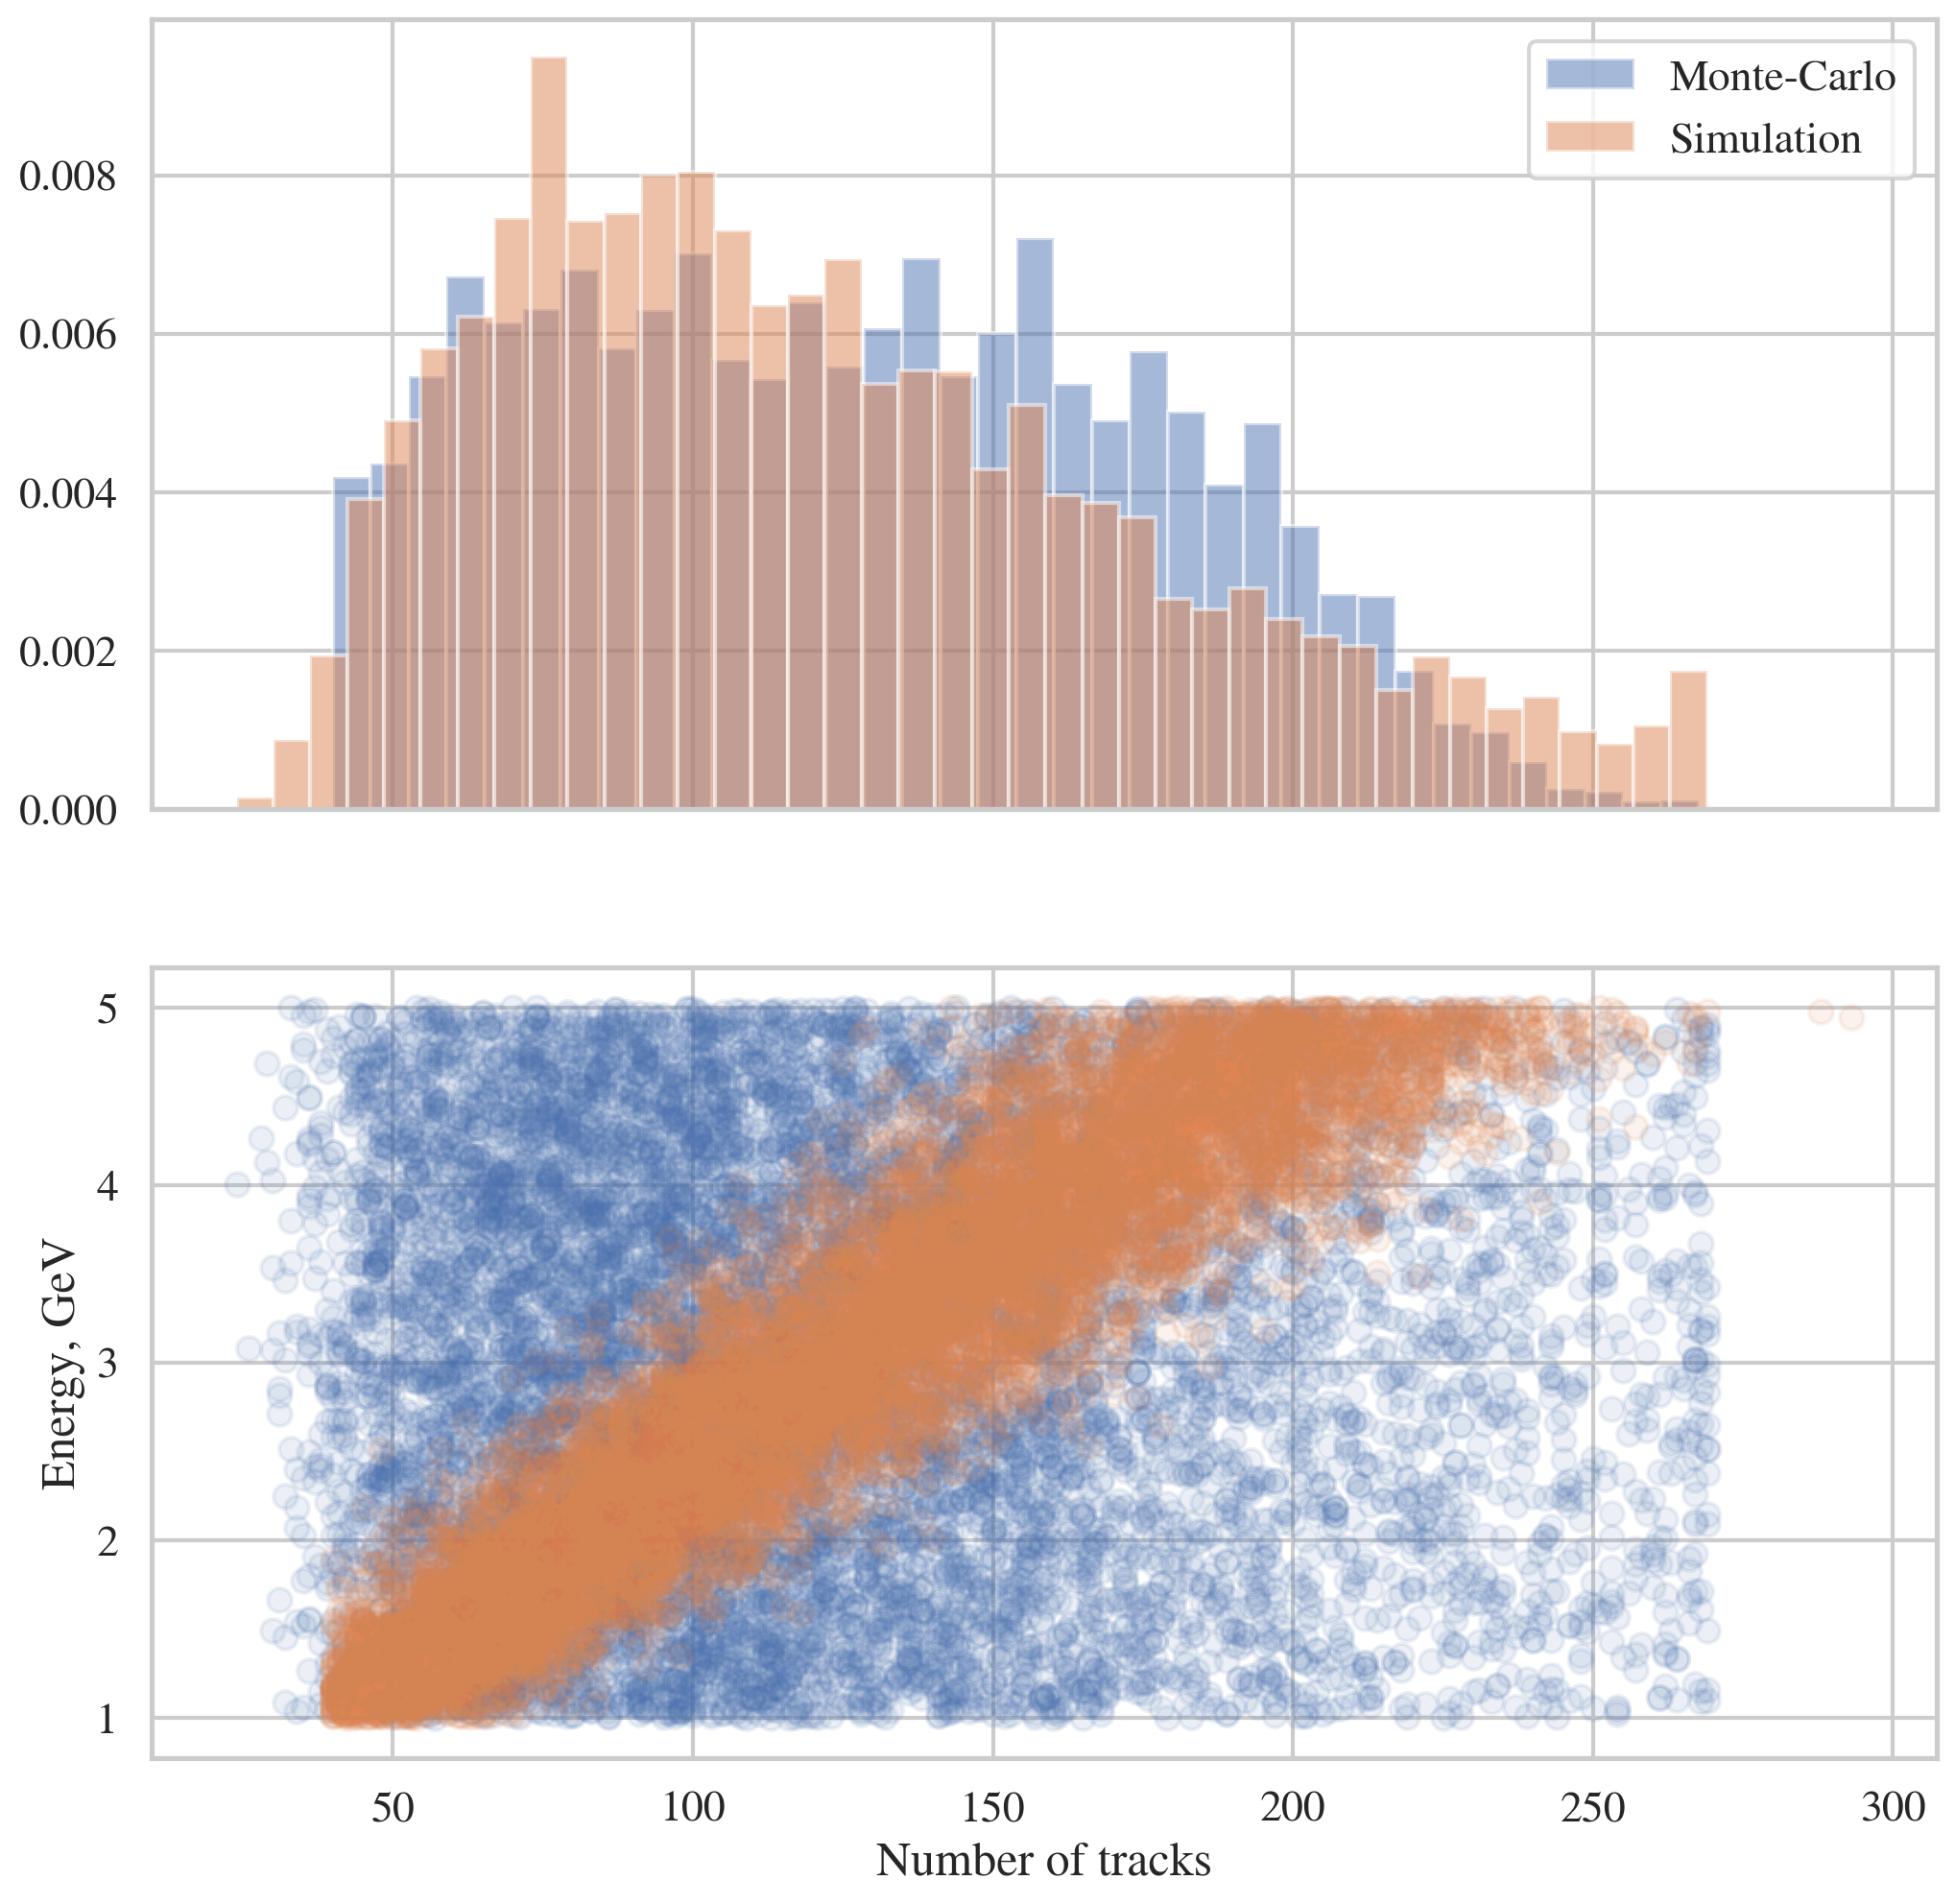

In [15]:
f, ax = plt.subplots(2, 1, dpi=200, figsize=(12, 12), sharex=True)

ax[0].hist(lengths_real, density=True, alpha=0.5, bins=40, label='Monte-Carlo');
ax[0].hist(20 + lengths[lengths < 250], alpha=0.5, density=True, bins=40, label='Simulation')

ax[1].scatter(lengths, np.array(energies)[lengths < 250], alpha=0.1)
ax[1].scatter(lengths_real, energies_real, alpha=0.1)

ax[1].set_xlabel('Number of tracks')
ax[1].set_ylabel('Probability density')
ax[1].set_ylabel('Energy, GeV')
ax[0].legend()
plt.show()

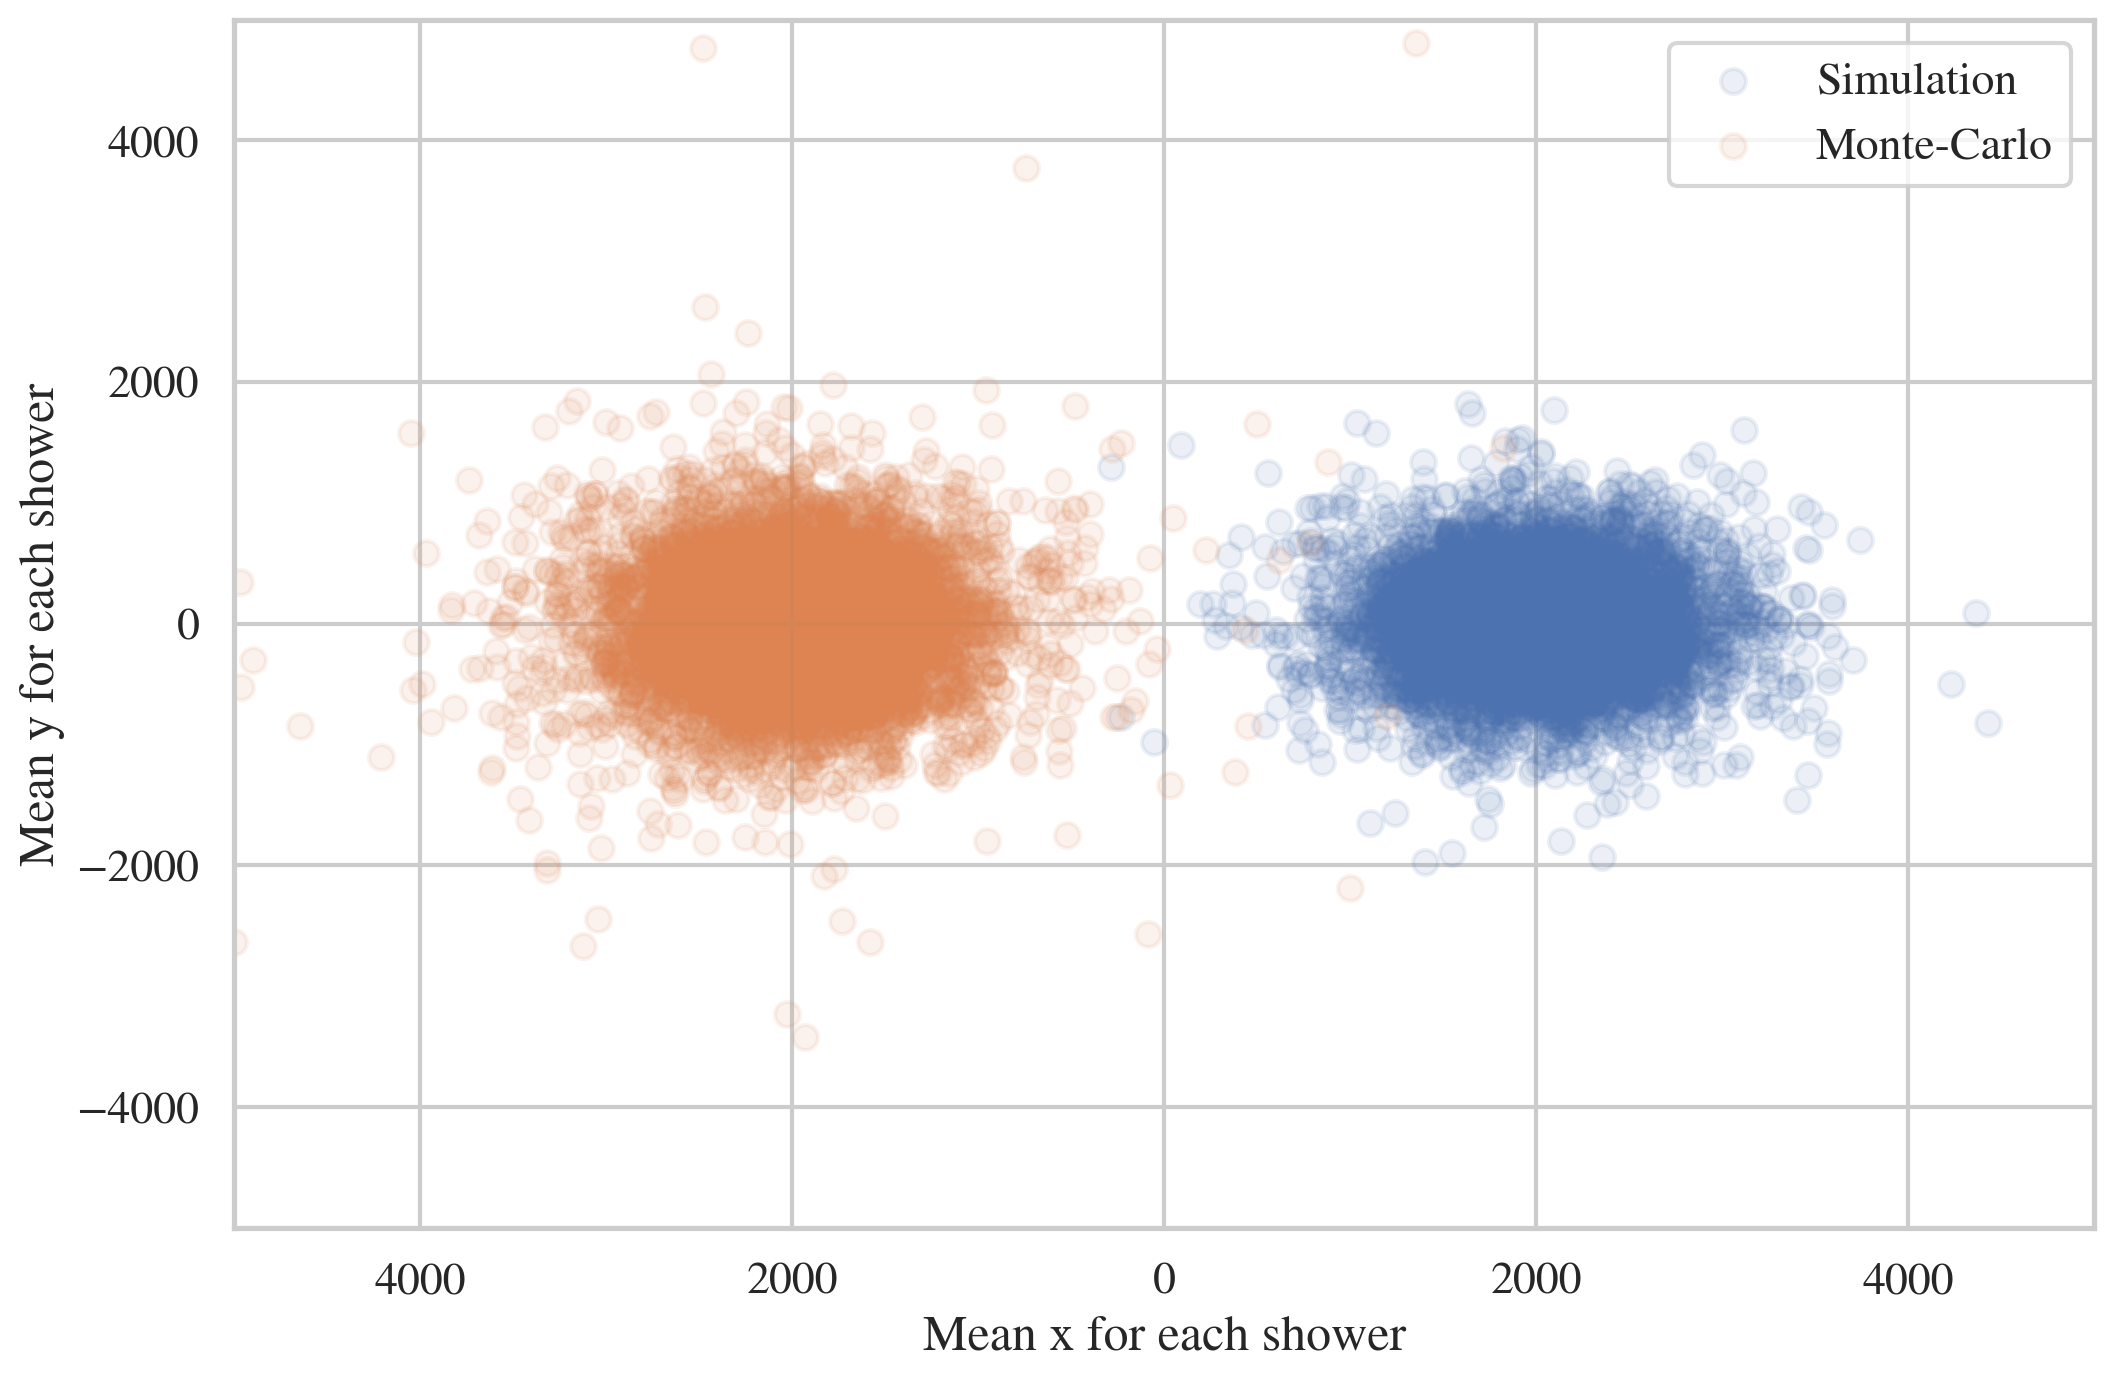

In [18]:
plt.figure(figsize=(12, 8), dpi=200)
plt.scatter(mean_x + 2000, mean_y, alpha=0.1, label='Simulation')
plt.scatter(mean_x_real - 2000, mean_y_real, alpha=0.1, label='Monte-Carlo')
plt.xlim(-5000, 5000)
plt.ylim(-5000, 5000)

# x = [0.00001,0.001,0.01,0.1,0.5,1,5]
# xi = 
x = [-4000, -2000, 0, 2000, 4000]
xi = np.abs(x)
plt.xticks(x, xi)
plt.xlabel("Mean x for each shower")
plt.ylabel("Mean y for each shower")
plt.legend()
plt.show()

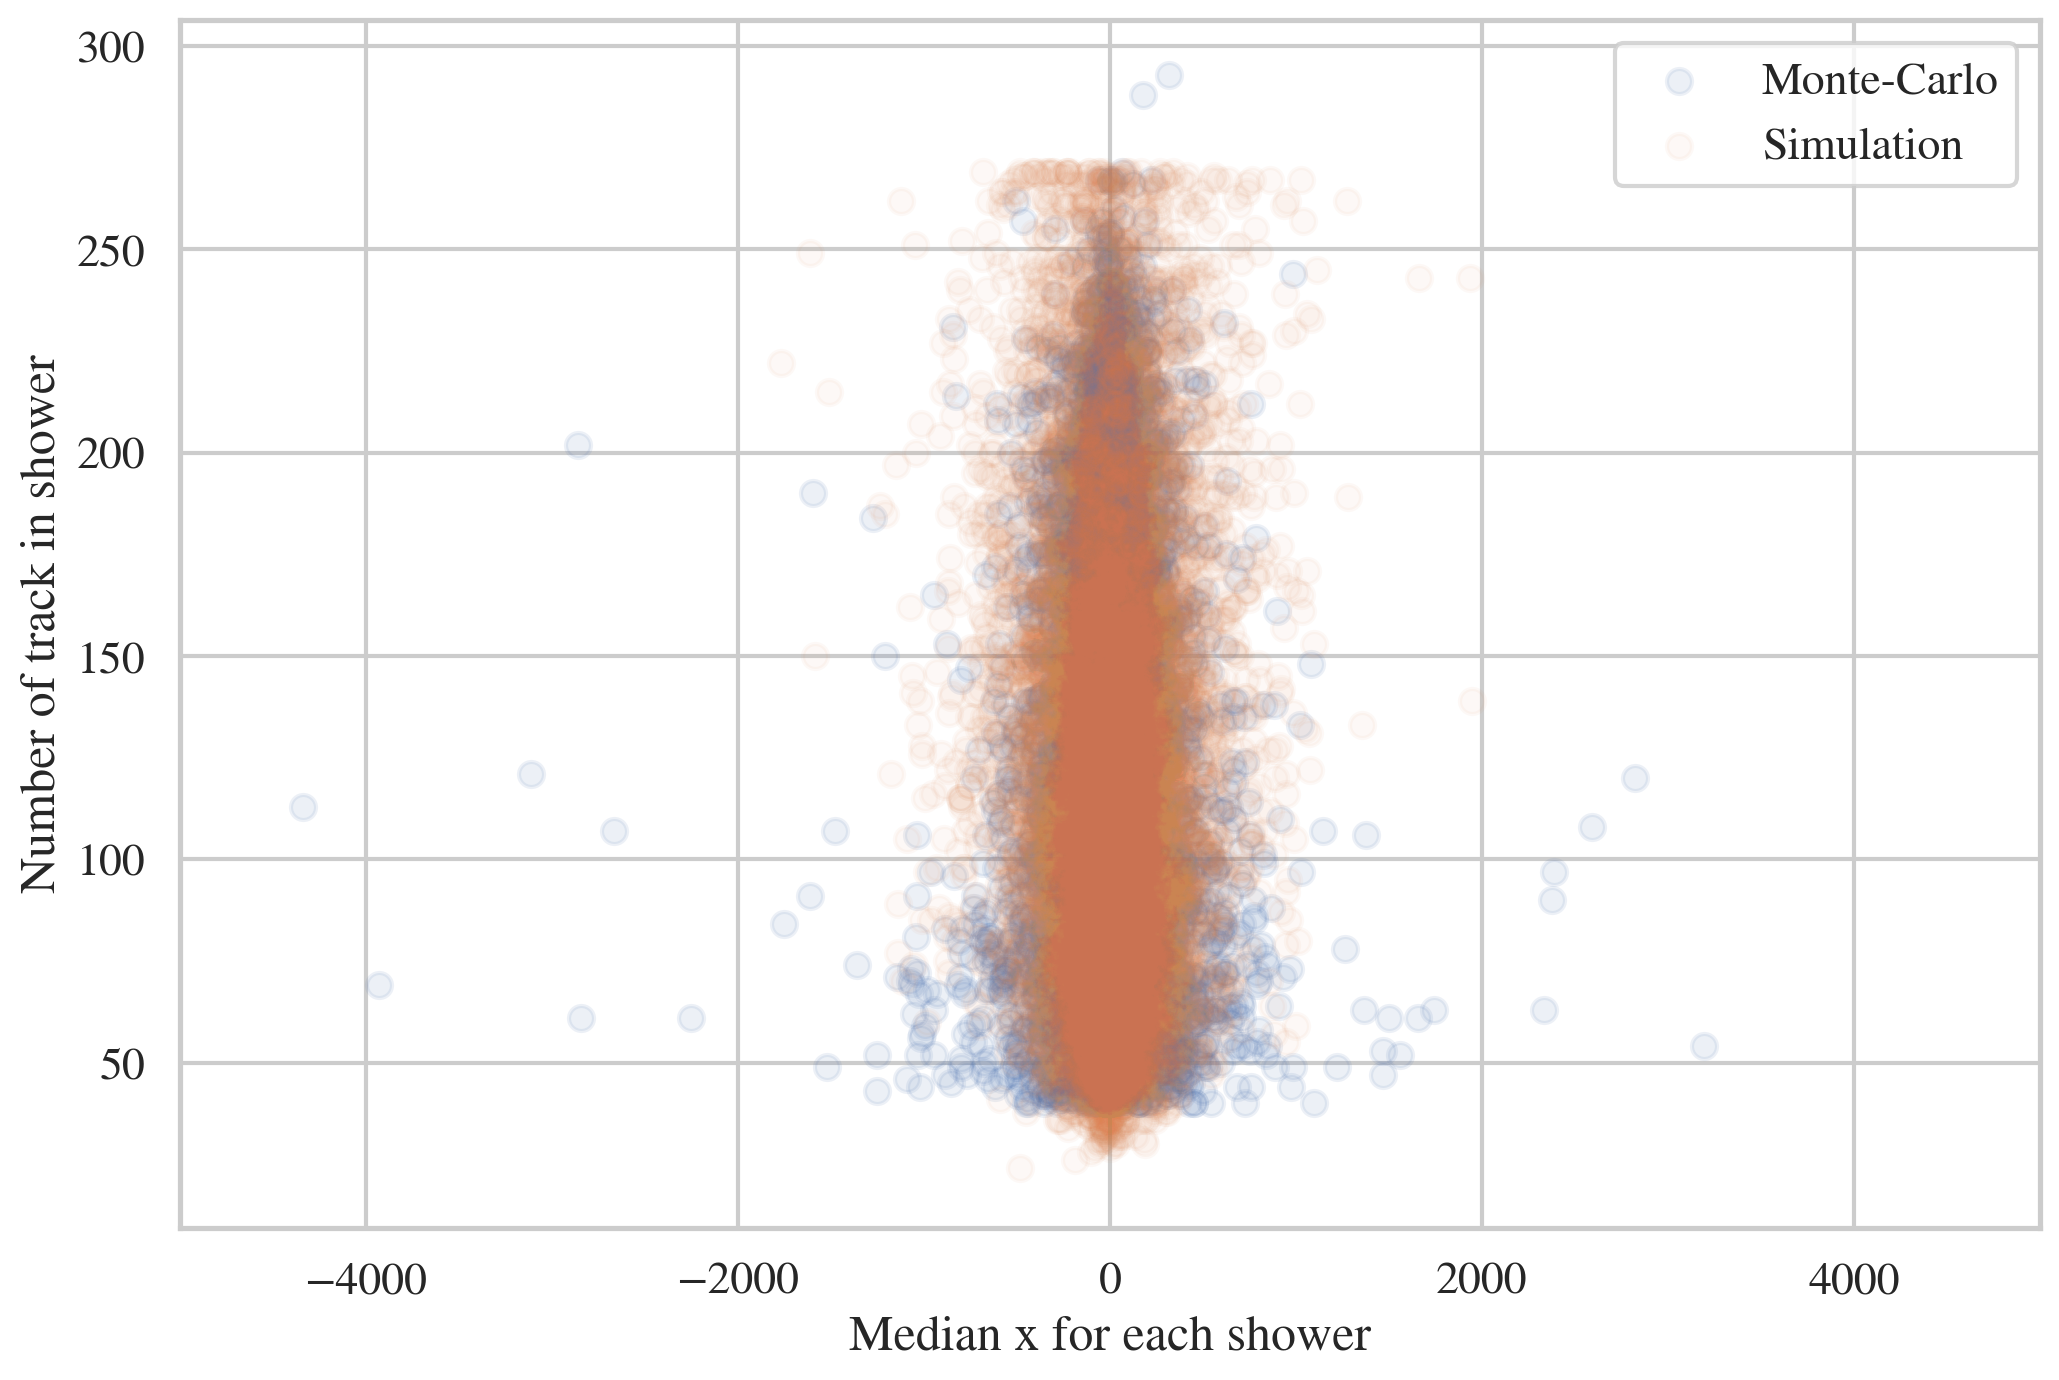

In [20]:
plt.figure(figsize=(12, 8), dpi=200)
plt.scatter(med_x_real, lengths_real, alpha=0.1, label='Monte-Carlo')
plt.scatter(med_x, lengths, alpha=0.05, label='Simulation')
plt.xlabel("Median x for each shower")
plt.ylabel("Number of track in shower")
plt.xlim(-5000, 5000)
plt.legend()
plt.show()